In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

cu = 3.e14   #speed of light in um/s
cA = 3.e18   #speed of light in A/s

In [2]:
def sum(array, lam):  #Sums the values in a template: (SUM(F_nu * dnu)) 
    a = len(array)
    tot = 0.
    
    for i in range(a-1):
        dlam = abs(lam[i+1] - lam[i])
        dnu = cu / lam[i]**2 * dlam

        tot += array[i] * dnu
        
    return tot

In [3]:
def wise():       #Reads in the WISE data
    # Reads in the AB magnitudes, errors, and flux range in um for each object
    magAB = np.loadtxt('AB_mags.txt')
    errors = np.loadtxt('AB_errors.txt')
    with open('objects.txt') as f:
        objects = f.readlines()
        objects = [line.rstrip('\n') for line in open('objects.txt')]
    
    wise_flux = np.zeros((15,8))
    wise_fluxerr = np.zeros((15,8))

    
    for i in range(15):
        for j in range(8):
            if errors[i,j] == 9.999:
                errors[i,j] = 0.000
            if magAB[i,j] == 0.:
                continue
            wise_flux[i,j] = 10**(-0.4*(magAB[i,j] - 8.926))
            wise_fluxerr[i,j] = 10**(-0.4*(magAB[i,j] + errors[i,j] - 8.926))
            
            if wise_flux[i,j] > 10000000.:
                print i,j
    
    wise_error = wise_fluxerr - wise_flux

    #Array containing the wavelengths for each WISE object in each band: (g r J Ks W1 W2 W3 W4)
    wise_lam = np.zeros((15,8))

    for i in range(15):
        wise_lam[i] = (0.474, 0.620, 1.247, 2.163, 3.4, 4.6, 12., 22.)
        
    #WISE values of row1: W2 - W3, and row2: W1 - W2
    wise_w123 = np.zeros((2,15))
    for i in range(15):
        #The magnitudes are converted back into Vega mags, which were the magnitudes used by Lonsdale et. al.
        wise_w123[0,i] = (magAB[i,5] - 3.339) - (magAB[i,6] - 5.174)
        wise_w123[1,i] = (magAB[i,4] - 2.699) - (magAB[i,5] - 3.339)
        
    return wise_flux, wise_lam, wise_error, wise_w123, objects

In [4]:
def load_gal():
    galaxy = np.zeros((10,300))
    names = ['ELL2','ELL5','ELL13','S0','Sa','Sb','Sc','Sd','M82','ARP220']

    ELL2_orig = np.loadtxt('templates_recast/ELL2.txt')
    ELL5_orig = np.loadtxt('templates_recast/ELL5.txt')
    ELL13_orig = np.loadtxt('templates_recast/ELL13.txt')
    S0_orig = np.loadtxt('templates_recast/S0.txt')
    Sa_orig = np.loadtxt('templates_recast/Sa.txt')
    Sb_orig = np.loadtxt('templates_recast/Sb.txt')
    Sc_orig = np.loadtxt('templates_recast/Sc.txt')
    Sd_orig = np.loadtxt('templates_recast/Sd.txt')
    M82_orig = np.loadtxt('templates_recast/M82.txt')
    ARP220_orig = np.loadtxt('templates_recast/ARP220.txt')
    
    galaxy[0] = ELL2_orig[0]
    galaxy[1] = ELL5_orig[0]
    galaxy[2] = ELL13_orig[0]
    galaxy[3] = S0_orig[0]
    galaxy[4] = Sa_orig[0]
    galaxy[5] = Sb_orig[0]
    galaxy[6] = Sc_orig[0]
    galaxy[7] = Sd_orig[0]
    galaxy[8] = M82_orig[0]
    galaxy[9] = ARP220_orig[0]
    
    return galaxy, names

In [5]:
def gal_ad(gal_orig, qso_orig, p):
    gal = np.zeros(len(gal_orig))

    gal[237] = qso_orig[237] / p
    x = gal[237] / gal_orig[237]
    for j in range(len(gal_orig)):
        gal[j] = gal_orig[j] * x
        
    return gal

In [6]:
def reddening(qso_orig, lam, A_V):
    R_V = 4.05

    A_lam = np.zeros(len(lam)) #Actually calculating A_lam / A_V

    const = (2.659/R_V * (-1.857 + 1.04/2.2) + 1.0) * 2.2**1.8
    const1 = (2.659/R_V * (-2.156 + 1.509/0.1 - 0.198/(0.1**2) + 0.011/(0.1**3)) + 1.0) * 0.1**1.8
        
    for i in range(len(lam)):
        if lam[i] >= 0.12:
            if lam[i] < 0.63:
                A_lam[i] = 2.659/R_V * (-2.156 + 1.509/lam[i] - 0.198/(lam[i]**2) + 0.011/(lam[i]**3)) + 1.0
        if lam[i] >= 0.63:
            if lam[i] <= 2.20:
                A_lam[i] = 2.659/R_V * (-1.857 + 1.04/lam[i]) + 1.0
            elif lam[i] > 2.20:
                A_lam[i] = const * lam[i]**-1.8
        if lam[i] < 0.12:
            A_lam[i] = const1 * lam[i]**-1.8
    
    QSO_red = np.zeros(len(qso_orig))
    
    for i in range(len(qso_orig)):
        QSO_red[i] = qso_orig[i] * 10**(-0.4 * A_V * A_lam[i])
        
    return QSO_red

In [7]:
def planck(lam, p_lam, qso_orig, qso_red, T):
    planck = p_lam**(-3) / (np.exp(14400. / p_lam / T)-1)    #Planck function
    
    dust_abs = sum(qso_orig,lam) - sum(qso_red,lam)
    planck_func = np.zeros(len(p_lam))

    alpha = dust_abs / sum(planck,p_lam)
    planck_func = planck * alpha
    
    return planck_func

In [8]:
def f2mag(val, num):   #Converts the W1, W2, and W3 fluxes in the template to Vega magnitudes
    if num == 1.:
        mag = -2.5 * np.log10(1e23 * val) + 8.962 - 2.699
    elif num == 2.:
        mag = -2.5 * np.log10(1e23 * val) + 8.962 - 3.339
    elif num == 3.:
        mag = -2.5 * np.log10(1e23 * val) + 8.962 - 5.174
    
    return mag

In [9]:
def norm(template, lam, wise_flux, wise_lam):  #normalizes to template to the g-band point of the WISE data
    c = 0.
    tot = 0.
    temp = np.zeros(len(template))
    
    for k in range(len(template)):  #making a new, cloned template, because without doing this it update the input 
        temp[k] = template[k]       #template, and I don't want that
        
    for j in range(len(lam)):
        if lam[j] >= wise_lam - 0.02:
            if lam[j] <= wise_lam + 0.02:
                c += 1.
                tot += temp[j]
    avg = tot / c
    
    x = avg / wise_flux
    temp /= x
    
    return temp

In [10]:
class InteractPlot:     
    def __init__(self):
        #Defines the first figure which holds the W2-W3 v W1-W2 points and graph
        self.fig1 = plt.figure(figsize=(12,6))
        plt.clf()
        self.ax1 = self.fig1.add_subplot(121)
        plt.subplots_adjust(left=0.25, bottom=0.35)
        plt.axis([2.5,6,0.0,3.5])
    
        x = np.arange(-1,10,.1)
        plt.plot(x, x/x*0.8, 'k--')
        plt.plot(x, -1.25*x + 7, 'k--')
        
        plt.xlabel('W2 - W3')
        plt.ylabel('W1 - W2')
        plt.title('W1 - W2 - W3 Plot w/ Vega Magnitudes')
        
        #Defines the figures which will plot the SED on top of each set of WISE points
        self.ax2 = self.fig1.add_subplot(122)
        
    def plot(self, xdata, ydata, ptype):
        self.ax1.plot(xdata, ydata, ptype)
        
    a = 0             #defines which object will be plotted with the SED (0 <= i <= 14)
    b = 0             #defines which galaxy type will be the first one plotted
        
    def update(self,val):
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        sp.valtext.set_text("%.2f" % p)
        av = sav.val
        t = 10**(st.val)
        st.valtext.set_text("%.2f" % t)
        z = sz.val
        
        self.a %= 15
        self.b %= 10
    
        wise_lam_new = wise_lam[self.a] / (z + 1)
    
        gal = gal_ad(galaxy[self.b], QSO_orig[0], p) 
        QSO_red = reddening(QSO_new, QSO_lam, av)
        p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, t)

        template = np.zeros(len(gal))

        for j in range(len(gal)):
            template[j] += gal[j]
            template[j] += p_func[j+100]
            template[j] += QSO_red[j]
        
        zshift = int(100*np.log10(z + 1))
        W1 = f2mag(template[147 + zshift], 1)
        W2 = f2mag(template[134 + zshift], 2)
        W3 = f2mag(template[92 + zshift], 3)
        
        l.set_xdata(W2-W3)
        l.set_ydata(W1-W2)
    
        temp = norm(template, lam, wise_flux[self.a,0], wise_lam_new[0])     #normalizes the template to the g-band
        n_factor = np.log10(temp[1]) - np.log10(template[1])
    
        self.ax2.cla()
        self.ax2.plot(-np.log10(wise_lam_new), np.log10(wise_flux[self.a]), 'b.', label=objects[self.a])
        self.ax2.set_title(objects[self.a] + ' w/ ' + gal_names[self.b])
        self.ax2.set_xlabel('-log($\lambda$)')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.yaxis.tick_right()
        self.ax2.set_ylabel('log(F$_{nu}$)')
        self.ax2.axis([-2,1,-10,-0]) 
        self.ax2.plot(negloglam, np.log10(temp), 'r-')
        self.ax2.plot(p_negloglam, np.log10(p_func) + n_factor, 'g--')
        self.ax2.plot(negloglam, np.log10(gal) + n_factor, 'y--')
        self.ax2.plot(QSO_negloglam, np.log10(QSO_red) + n_factor, 'm--')
        self.ax2.plot(negloglam, np.log10(QSO_orig[0]) + n_factor, 'c--')
        self.ax2.text(-1.25, -1, r'$\beta=' + str(int(p)) + ',\ A_V=' + str(int(av)) + ',\ T=' + 
                      str(int(t)) + ', z=' + str(round(z,2)) + '$')
        self.ax2.draw()
        
    def next_gal(self, event):
        self.b += 1
        
        self.a %= 15
        self.b %= 10
        
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        sp.valtext.set_text("%.2f" % p)
        av = sav.val
        t = 10**(st.val)
        st.valtext.set_text("%.2f" % t)
        z = sz.val
    
        wise_lam_new = wise_lam[self.a] / (z + 1)
    
        gal = gal_ad(galaxy[self.b], QSO_orig[0], p) 
        QSO_red = reddening(QSO_new, QSO_lam, av)
        p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, t)

        template = np.zeros(len(gal))

        for j in range(len(gal)):
            template[j] += gal[j]
            template[j] += p_func[j+100]
            template[j] += QSO_red[j]
        
        zshift = int(100*np.log10(z + 1))
        W1 = f2mag(template[147 + zshift], 1)
        W2 = f2mag(template[134 + zshift], 2)
        W3 = f2mag(template[92 + zshift], 3)
        
        l.set_xdata(W2-W3)
        l.set_ydata(W1-W2)
    
        temp = norm(template, lam, wise_flux[self.a,0], wise_lam_new[0])     #normalizes the template to the g-band
        n_factor = np.log10(temp[1]) - np.log10(template[1])
    
        self.ax2.cla()
        self.ax2.plot(-np.log10(wise_lam_new), np.log10(wise_flux[self.a]), 'b.', label=objects[self.a])
        self.ax2.set_title(objects[self.a] + ' w/ ' + gal_names[self.b])
        self.ax2.set_xlabel('-log($\lambda$)')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.yaxis.tick_right()
        self.ax2.set_ylabel('log(F$_{nu}$)')
        self.ax2.axis([-2,1,-10,-0]) 
        self.ax2.plot(negloglam, np.log10(temp), 'r-')
        self.ax2.plot(p_negloglam, np.log10(p_func) + n_factor, 'g--')
        self.ax2.plot(negloglam, np.log10(gal) + n_factor, 'y--')
        self.ax2.plot(QSO_negloglam, np.log10(QSO_red) + n_factor, 'm--')
        self.ax2.plot(negloglam, np.log10(QSO_orig[0]) + n_factor, 'c--')
        self.ax2.text(-1.25, -1, r'$\beta=' + str(int(p)) + ',\ A_V=' + str(int(av)) + ',\ T=' + 
                      str(int(t)) + ', z=' + str(round(z,2)) + '$')
        self.ax2.draw()
        
    def prev_gal(self, event):
        self.b -= 1
        
        self.a %= 15
        self.b %= 10
        
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        sp.valtext.set_text("%.2f" % p)
        av = sav.val
        t = 10**(st.val)
        st.valtext.set_text("%.2f" % t)
        z = sz.val
    
        wise_lam_new = wise_lam[self.a] / (z + 1)
    
        gal = gal_ad(galaxy[self.b], QSO_orig[0], p) 
        QSO_red = reddening(QSO_new, QSO_lam, av)
        p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, t)

        template = np.zeros(len(gal))

        for j in range(len(gal)):
            template[j] += gal[j]
            template[j] += p_func[j+100]
            template[j] += QSO_red[j]
        
        zshift = int(100*np.log10(z + 1))
        W1 = f2mag(template[147 + zshift], 1)
        W2 = f2mag(template[134 + zshift], 2)
        W3 = f2mag(template[92 + zshift], 3)
        
        l.set_xdata(W2-W3)
        l.set_ydata(W1-W2)
    
        temp = norm(template, lam, wise_flux[self.a,0], wise_lam_new[0])     #normalizes the template to the g-band
        n_factor = np.log10(temp[1]) - np.log10(template[1])
    
        self.ax2.cla()
        self.ax2.plot(-np.log10(wise_lam_new), np.log10(wise_flux[self.a]), 'b.', label=objects[self.a])
        self.ax2.set_title(objects[self.a] + ' w/ ' + gal_names[self.b])
        self.ax2.set_xlabel('-log($\lambda$)')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.yaxis.tick_right()
        self.ax2.set_ylabel('log(F$_{nu}$)')
        self.ax2.axis([-2,1,-10,-0]) 
        self.ax2.plot(negloglam, np.log10(temp), 'r-')
        self.ax2.plot(p_negloglam, np.log10(p_func) + n_factor, 'g--')
        self.ax2.plot(negloglam, np.log10(gal) + n_factor, 'y--')
        self.ax2.plot(QSO_negloglam, np.log10(QSO_red) + n_factor, 'm--')
        self.ax2.plot(negloglam, np.log10(QSO_orig[0]) + n_factor, 'c--')
        self.ax2.text(-1.25, -1, r'$\beta=' + str(int(p)) + ',\ A_V=' + str(int(av)) + ',\ T=' + 
                      str(int(t)) + ', z=' + str(round(z,2)) + '$')
        self.ax2.draw()
        
    def next_obj(self, event):
        self.a += 1
        
        self.a %= 15
        self.b %= 10
        
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        sp.valtext.set_text("%.2f" % p)
        av = sav.val
        t = 10**(st.val)
        st.valtext.set_text("%.2f" % t)
        z = sz.val
    
        wise_lam_new = wise_lam[self.a] / (z + 1)
    
        gal = gal_ad(galaxy[self.b], QSO_orig[0], p) 
        QSO_red = reddening(QSO_new, QSO_lam, av)
        p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, t)

        template = np.zeros(len(gal))

        for j in range(len(gal)):
            template[j] += gal[j]
            template[j] += p_func[j+100]
            template[j] += QSO_red[j]
        
        zshift = int(100*np.log10(z + 1))
        W1 = f2mag(template[147 + zshift], 1)
        W2 = f2mag(template[134 + zshift], 2)
        W3 = f2mag(template[92 + zshift], 3)
        
        self.ax1.cla()

        self.ax1.axis([2.5,6,0.0,3.5])
    
        x = np.arange(-1,10,.1)
        self.ax1.plot(x, x/x*0.8, 'k--')
        self.ax1.plot(x, -1.25*x + 7, 'k--')
        
        self.ax1.set_xlabel('W2 - W3')
        self.ax1.set_ylabel('W1 - W2')
        self.ax1.set_title('W1 - W2 - W3 Plot w/ Vega Magnitudes')
        self.ax1.plot(wise_w123[0,self.a], wise_w123[1,self.a], 'b.')
        self.ax1.annotate(
            objects[self.a],
            xy=(wise_w123[0,self.a], wise_w123[1,self.a]), xytext=(20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.4),
            arrowprops=dict(arrowstyle = '-|>', connectionstyle='arc3,rad=0'))
    
        temp = norm(template, lam, wise_flux[self.a,0], wise_lam_new[0])     #normalizes the template to the g-band
        n_factor = np.log10(temp[1]) - np.log10(template[1])
    
        self.ax2.cla()
        self.ax2.plot(-np.log10(wise_lam_new), np.log10(wise_flux[self.a]), 'b.', label=objects[self.a])
        self.ax2.set_title(objects[self.a] + ' w/ ' + gal_names[self.b])
        self.ax2.set_xlabel('-log($\lambda$)')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.yaxis.tick_right()
        self.ax2.set_ylabel('log(F$_{nu}$)')
        self.ax2.axis([-2,1,-10,-0]) 
        self.ax2.plot(negloglam, np.log10(temp), 'r-')
        self.ax2.plot(p_negloglam, np.log10(p_func) + n_factor, 'g--')
        self.ax2.plot(negloglam, np.log10(gal) + n_factor, 'y--')
        self.ax2.plot(QSO_negloglam, np.log10(QSO_red) + n_factor, 'm--')
        self.ax2.plot(negloglam, np.log10(QSO_orig[0]) + n_factor, 'c--')
        self.ax2.text(-1.25, -1, r'$\beta=' + str(int(p)) + ',\ A_V=' + str(int(av)) + ',\ T=' + 
                      str(int(t)) + ', z=' + str(round(z,2)) + '$')
        self.ax2.draw()
        
    def prev_obj(self, event):
        self.a -= 1
        
        self.a %= 15
        self.b %= 10
        
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        sp.valtext.set_text("%.2f" % p)
        av = sav.val
        t = 10**(st.val)
        st.valtext.set_text("%.2f" % t)
        z = sz.val
    
        wise_lam_new = wise_lam[self.a] / (z + 1)
    
        gal = gal_ad(galaxy[self.b], QSO_orig[0], p) 
        QSO_red = reddening(QSO_new, QSO_lam, av)
        p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, t)

        template = np.zeros(len(gal))

        for j in range(len(gal)):
            template[j] += gal[j]
            template[j] += p_func[j+100]
            template[j] += QSO_red[j]
        
        zshift = int(100*np.log10(z + 1))
        W1 = f2mag(template[147 + zshift], 1)
        W2 = f2mag(template[134 + zshift], 2)
        W3 = f2mag(template[92 + zshift], 3)
        
        self.ax1.cla()

        self.ax1.axis([2.5,6,0.0,3.5])
    
        x = np.arange(-1,10,.1)
        self.ax1.plot(x, x/x*0.8, 'k--')
        self.ax1.plot(x, -1.25*x + 7, 'k--')
        
        self.ax1.set_xlabel('W2 - W3')
        self.ax1.set_ylabel('W1 - W2')
        self.ax1.set_title('W1 - W2 - W3 Plot w/ Vega Magnitudes')
        self.ax1.plot(wise_w123[0,self.a], wise_w123[1,self.a], 'b.')
        self.ax1.annotate(
            objects[self.a],
            xy=(wise_w123[0,self.a], wise_w123[1,self.a]), xytext=(20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.4),
            arrowprops=dict(arrowstyle = '-|>', connectionstyle='arc3,rad=0'))
    
        temp = norm(template, lam, wise_flux[self.a,0], wise_lam_new[0])     #normalizes the template to the g-band
        n_factor = np.log10(temp[1]) - np.log10(template[1])
    
        self.ax2.cla()
        self.ax2.plot(-np.log10(wise_lam_new), np.log10(wise_flux[self.a]), 'b.', label=objects[self.a])
        self.ax2.set_title(objects[self.a] + ' w/ ' + gal_names[self.b])
        self.ax2.set_xlabel('-log($\lambda$)')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.yaxis.tick_right()
        self.ax2.set_ylabel('log(F$_{nu}$)')
        self.ax2.axis([-2,1,-10,-0]) 
        self.ax2.plot(negloglam, np.log10(temp), 'r-')
        self.ax2.plot(p_negloglam, np.log10(p_func) + n_factor, 'g--')
        self.ax2.plot(negloglam, np.log10(gal) + n_factor, 'y--')
        self.ax2.plot(QSO_negloglam, np.log10(QSO_red) + n_factor, 'm--')
        self.ax2.plot(negloglam, np.log10(QSO_orig[0]) + n_factor, 'c--')
        self.ax2.text(-1.25, -1, r'$\beta=' + str(int(p)) + ',\ A_V=' + str(int(av)) + ',\ T=' + 
                      str(int(t)) + ', z=' + str(round(z,2)) + '$')
        self.ax2.draw()
        
        
    def export(self, event):
        p = 10**(sp.val)         #retrieves current values from sliders and re-calculates the templates
        av = sav.val
        t = 10**(st.val)
        z = sz.val
        
        filename = 'parameters2.txt'
        f = open(filename, 'a')
        f.write(' ' + str(round(p,2)) + ' ' + str(round(av,2)) + ' ' + str(round(t,2)) + ' ' + 
                str(round(z,2)) + ' ' + str(int(self.a)) + ' ' + str(int(self.b)) + '\n')
        f.close()
        

# Main Program

<IPython.core.display.Javascript object>


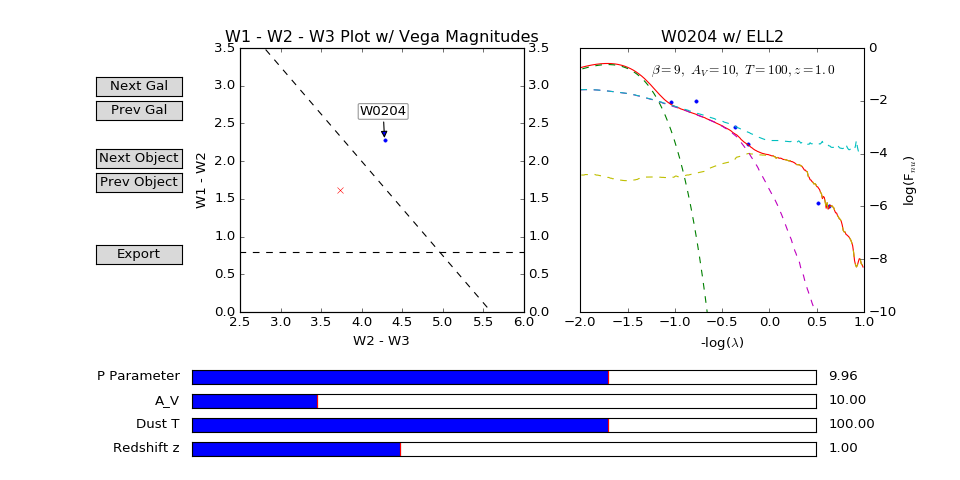

C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in log10


In [11]:
##########################Initializations##############################################
#loads WISE data
wise_flux, wise_lam, wise_error, wise_w123, objects = wise()
    
#The data from these templates is in two rows, the first row containing the flux, the second row containing the wavelength
#The flux is in units of [erg cm-2 s-1 Hz-1], while the wavelength is in [um]
QSO_orig = np.loadtxt('templates_recast/QSO1.txt')

galaxy, gal_names = load_gal()

lam = QSO_orig[1]                           #array of wavelengths
negloglam = -np.log10(lam)                  #array of -log(wavelength), [-2,1]
QSO_negloglam = np.arange(-2,3,0.01)        #array of new -log(wavelength) for QSO [-2,3]
QSO_lam = 10**(-QSO_negloglam)              #new QSO lambda
p_negloglam = np.arange(-3,1,0.01)          #array of -log(wavelength) for planck function, [-3,1]
p_lam = 10**(-p_negloglam)                  #array of wavelengths for planck function

QSO_new = np.zeros(len(QSO_negloglam))

for i in range(len(QSO_negloglam)):         #expands Quasar another 2 dex, setting it as const in nu*F_nu
    if i <= 299:
        QSO_new[i] = QSO_orig[0][i]
    else:
        QSO_new[i] = QSO_orig[0][299] * QSO_lam[i] / QSO_lam[299]
        
#initializes the plots
myplot = InteractPlot()

#initial values of the sliders and template   (p0 and T0 are log values)   
p0 = 1.
A_V0 = 10.
T0 = 2.
z0 = 1.

a0 = 0
b0 = 0

wise_lam_new = wise_lam[a0] / (z0 + 1)        #applies z-shift law to the WISE points
    
gal = gal_ad(galaxy[b0], QSO_orig[0], 10**(p0)) 
QSO_red = reddening(QSO_new, QSO_lam, A_V0)
p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, 10**(T0))

template = np.zeros(len(gal))

for j in range(len(gal)):
    template[j] += gal[j]
    template[j] += p_func[j+100]
    template[j] += QSO_red[j]

#Points corresponding to the wavelength bands are g-237 r-220 J-190 Ks-166 W1-147 W2-134 W3-92 W4-66
zshift = int(100*np.log10(z0 + 1))
W1 = f2mag(template[147 + zshift], 1)
W2 = f2mag(template[134 + zshift], 2)
W3 = f2mag(template[92 + zshift], 3)
    
#plots the WISE points on the first figure
myplot.plot(wise_w123[0,a0], wise_w123[1,a0], 'b.')
plt.subplot(121)
plt.annotate(
    objects[a0],
    xy=(wise_w123[0,a0], wise_w123[1,a0]), xytext=(20, 20),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.4),
    arrowprops=dict(arrowstyle = '-|>', connectionstyle='arc3,rad=0'))
    
ax_l = myplot.ax1.twinx()
plt.axis([2.5,6,0.0,3.5])
l, = plt.plot(W2-W3, W1-W2, 'rx')           #defines the point which will be slid on the color plot
axp = plt.axes([0.2, 0.20, 0.65, 0.03])     #defines the position of the sliders
axav = plt.axes([0.2, 0.15, 0.65, 0.03])
axt = plt.axes([0.2, 0.1, 0.65, 0.03])
axz = plt.axes([0.2, 0.05, 0.65, 0.03])

axnextgal = plt.axes([0.1, 0.80, 0.09, 0.04])
axprevgal = plt.axes([0.1, 0.75, 0.09, 0.04])
axnextobj = plt.axes([0.1, 0.65, 0.09, 0.04])
axprevobj = plt.axes([0.1, 0.60, 0.09, 0.04])

axexport = plt.axes([0.1, 0.45, 0.09, 0.04])

#initializes the sliders
sp = Slider(axp, 'P Parameter', -1, 2, valinit=p0)
sav = Slider(axav, 'A_V', 0, 50, valinit=A_V0)
st = Slider(axt, 'Dust T', 0, 3, valinit=T0)
sz = Slider(axz, 'Redshift z', 0, 3, valinit=z0)  

bnextgal = Button(axnextgal, 'Next Gal')
bprevgal = Button(axprevgal, 'Prev Gal')
bnextobj = Button(axnextobj, 'Next Object')
bprevobj = Button(axprevobj, 'Prev Object')
bexport = Button(axexport, 'Export')

sp.on_changed(myplot.update)
sav.on_changed(myplot.update)
st.on_changed(myplot.update)  
sz.on_changed(myplot.update)

bnextgal.on_clicked(myplot.next_gal)
bprevgal.on_clicked(myplot.prev_gal)
bnextobj.on_clicked(myplot.next_obj)
bprevobj.on_clicked(myplot.prev_obj)
bexport.on_clicked(myplot.export)

plt.subplot(122)
plt.plot(-np.log10(wise_lam_new), np.log10(wise_flux[a0]), 'b.', label=objects[a0])
plt.title(objects[a0] + ' w/ ' + gal_names[b0])
plt.axis([-2,1,-10,-0])  

plt.show()